In [139]:
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.interpolate import approximate_taylor_polynomial as taylor
import sklearn.gaussian_process as skg
from scipy.special import erfc
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

In [3]:
f = lambda x: 1-2*x**2

In [167]:
lam = 1e-2
l = 0.25
kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(l, length_scale_bounds="fixed")
gpa = skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)
X = np.random.uniform(-1,1,3).reshape(-1,1).reshape(-1,1)
X = np.array([[-0.75],[0.75]])
y = f(X)
gpa.fit(X,y)
gpa.kernel_.get_params()

{'k1': 1**2,
 'k2': RBF(length_scale=0.25),
 'k1__constant_value': 1.0,
 'k1__constant_value_bounds': 'fixed',
 'k2__length_scale': 0.25,
 'k2__length_scale_bounds': 'fixed'}

In [168]:
xx = np.arange(-1,1,0.001)
mu_last, sigma_last = gpa.predict(xx.reshape(-1,1), return_std=True)
mu_last = mu_last.flatten()

Calculate raw $P_{err}$

In [169]:
p_err = 1/2*erfc(np.abs(mu_last)/sigma_last)

Calculate $\int_{-\infty}^\infty P_t^{err}(\phi,\phi_t)d\phi$

In [170]:
def gpa_next(gpa,x,y):

    g = skg.GaussianProcessRegressor(
        alpha=1e-2,
        kernel=kernel
    )
    g.fit(
        np.vstack((gpa.X_train_, np.array(x).reshape(-1,1))),
        np.vstack((gpa.y_train_, np.array(y).reshape(-1,1)))
    )
    # print(g.X_train_)
    return g

x_next_list = np.arange(-1,1,0.01)
util_exact = []

for x_next in x_next_list:

    y_next = gpa.predict(x_next.reshape(-1,1))
    g = gpa_next(
        gpa,
        x_next,
        y_next
        )
    m, s = g.predict(xx.reshape(-1,1), return_std=True)
    p_err_next = 1/2*erfc(np.abs(m)/s)
    util_exact.append(np.sum(p_err-p_err_next))

util_exact = np.array(util_exact)

Approximate $\int_{-\infty}^\infty \int_{-\infty}^\infty f(x_t) P_t^{err}(\phi,\phi_t)d\phi dx_t$ by assuming $P_t^{err}$ is locally linear

In [171]:
d = lambda a,b: np.linalg.norm(a-b)
k0 = lambda a,b: np.exp(-d(a,b)**2/2)

def kt1(gpa, x):
    xx = gpa.X_train_
    kt = [k0(x,x1) for x1 in xx]
    return np.array(kt).reshape(-1,1)

def Kt(gpa):
    xx = gpa.X_train_
    K = np.empty((3,3))
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            K[i,j] = k0(xx[i],xx[j])
    return K

def kt2(gpa, x1, x2):
    inv = np.linalg.pinv(Kt(gpa))
    m1 = np.dot(kt1(gpa,x1).transpose(), inv)
    return k0(x1,x2) - np.dot(np.dot(kt1(gpa,x1).transpose(), inv), kt1(gpa,x2))

def get_mu(gpa,x):
    return gpa.predict(np.array(x).reshape(-1,1))

def get_sigma(gpa,x):
    _,sigma = gpa.predict(np.array(x).reshape(-1,1), return_std=True)
    return sigma

print(get_mu(gpa,0))
print(get_sigma(gpa,0))

[[-0.00274975]]
[0.9998778]


In [172]:
def fdiff_1(f,x0,h):
    
    x0 = np.array(x0)
    num = f(x0+h) - f(x0-h)
    return num/(2*h)

def fdiff_2(f,x0,h):
    
    x0 = np.array(x0)
    num = f(x0+h) - 2*f(x0) + f(x0-h)
    return num/(h**2)

In [173]:
g = lambda x: (1/6)*x**3
fdiff_2(g,-2,0.1)

-2.0000000000000013e+00

In [174]:
def perr_next(gpa,x,xt,yt):
    
    g = gpa_next(gpa,xt,yt)
    return g.predict(np.array(x).reshape(-1,1))


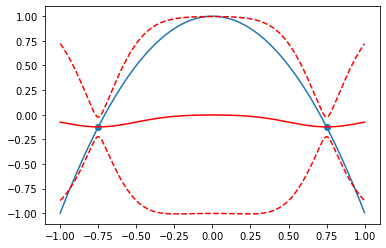

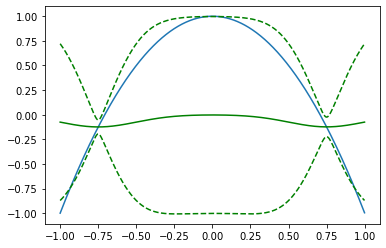

In [175]:
mu,sig = gpa.predict(xx.reshape(-1,1), return_std=True)
sig = sig.reshape(-1,1)
plt.plot(xx, f(xx))
plt.scatter(X, f(X))
plt.plot(xx,mu,'r')
plt.plot(xx,mu+sig,'r--',xx,mu-sig,'r--')
plt.show()

gpa_t = gpa_next(gpa, -0.75, f(-0.75))
mu,sig = gpa_t.predict(xx.reshape(-1,1), return_std=True)
sig = sig.reshape(-1,1)
plt.plot(xx, f(xx))
plt.plot(xx,mu,'g')
plt.plot(xx,mu+sig,'g--',xx,mu-sig,'g--')
plt.show()

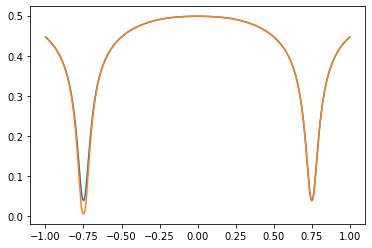

In [176]:
p = lambda mu, sig: 1/2*erfc(np.abs(mu)/sig)

mu,sig = gpa.predict(xx.reshape(-1,1), return_std=True)
sig = sig.reshape(-1,1)
p_err_tm1 = p(mu,sig)

mu,sig = gpa_t.predict(xx.reshape(-1,1), return_std=True)
sig = sig.reshape(-1,1)
p_err_t = p(mu,sig)

plt.plot(xx,p_err_tm1)
plt.plot(xx,p_err_t)
plt.show()

In [177]:
dx = 0.001
xx = np.arange(-1,1,dx)

In [178]:
# Calculate true cost function
def calc_true_cost(gpa,xx):
    mu, sig = gpa.predict(xx.reshape(-1,1), return_std=True)
    sig = sig.reshape(-1,1)
    p_err_last = p(mu,sig)

    cost = []
    for x_next in xx:

        y_next = gpa.predict(x_next.reshape(-1,1))
        gpn = gpa_next(gpa,x_next,y_next)
        mu_next, sig_next = gpn.predict(xx.reshape(-1,1),return_std=True)
        sig_next = sig_next.reshape(-1,1)

        p_err_t = p(mu_next, sig_next)
        integrated_err = np.sum(p_err_last - p_err_t)*dx
        cost.append(integrated_err)

    cost = np.array(cost)
    return cost

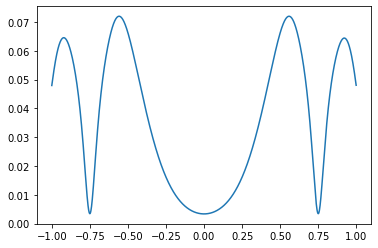

In [179]:
cost = calc_true_cost(gpa,xx)
plt.plot(xx,cost)

In [180]:
# Calculate truncated Taylor cost function

cost_approx = []
for x_next in xx:
    
    y_next = gpa.predict(x_next.reshape(-1,1))
    gpn = gpa_next(gpa,x_next,y_next)
    
    mu_next, sig_next = gpn.predict(xx.reshape(-1,1),return_std=True)
    sig_next = sig_next.reshape(-1,1)
        
    p_err_t = p(mu_next, sig_next)
    
    # Sample the GPA at x={x0-h, x0, x0+h}
    h=0.01
    x_sample = np.array([x_next-h, x_next, x_next+h]).reshape(-1,1)
    
    mu, sig = gpn.predict(xx.reshape(-1,1), return_std=True)
    sig = sig.reshape(-1,1)
    p_err = p(mu,sig)
    
    mu, sig = gpn.predict(x_sample, return_std=True)
    sig = sig.reshape(-1,1)
    p_err = p(mu,sig)
    
    d0 = p_err[1]
    d2 = (p_err[0] - 2*p_err[1] + p_err[2])/h**2
    
    # plt.plot(xx,np.ones_like(xx)*d0)
    # plt.show()
    
    integrated_err = 4*d0 + 16/6*d2    
    cost_approx.append(integrated_err)
    
cost_approx = np.array(cost_approx)

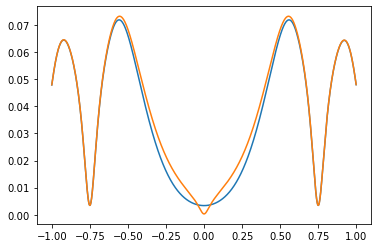

In [181]:
plt.plot(xx,calc_true_cost(gpa,xx))
# plt.plot(xx,cost_approx)
x_next = np.array(0.)
y_next = gpa.predict(x_next.reshape(-1,1))
gpn = gpa_next(gpa,x_next,y_next)
plt.plot(xx,calc_true_cost(gpn,xx))
plt.show()

In [182]:
def perr_fdiff(gpa,orders,x0,h=0.01):
    
    x_sample = np.array([x0-2*h, x0-h, x0, x0+h, x0+2*h]).reshape(-1,1)
    
    mu, sig = gpn.predict(x_sample.reshape(-1,1),return_std=True)
    sig = sig.reshape(-1,1)
    p_err_sample = p(mu, sig)
    
    fdiffs = []
    for i in orders:
        if i==0:
            fdiffs.append(p_err_sample[2])
        elif i==1:
            fdiffs.append((p_err_sample[3] - p_err_sample[1])/(2*h))
        elif i==2:
            fdiffs.append((p_err_sample[1] - 2*p_err_sample[2] + p_err_sample[3])/h**2)
        elif i==3:
            fdiffs.append((p_err_sample[0] - 2*p_err_sample[1] + 2*p_err_sample[3] - p_err_sample[4])/(2*h**3))
        elif i==4:
            fdiffs.append((p_err_sample[4] - 4*p_err_sample[3] + 6*p_err_sample[2] - 4*p_err_sample[1] + p_err_sample[0])/(h**4))
            
    return np.array(fdiffs)

In [183]:
perr_fdiff(gpa,[2],0,h=0.01)

array([[20.3728406]])

In [184]:
mu,sig = gpn.predict(xx.reshape(-1,1), return_std=True)
sig = sig.reshape(-1,1)
p_err_t = p(mu,sig)

[[0.48370945]
 [0.45563663]
 [0.36375787]
 [0.40514194]
 [0.42396645]]
[[ 3.63757871e-01]
 [-5.04946837e-01]
 [ 5.33051321e+01]
 [-1.64985460e+02]
 [-5.64625861e+04]]


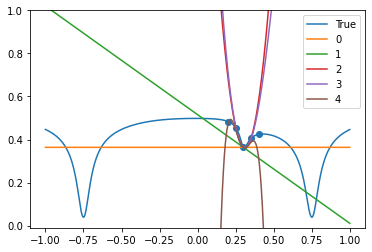

In [185]:
x_next = np.array(0.3)
y_next = gpa.predict(x_next.reshape(-1,1))
gpn = gpa_next(gpa,x_next,y_next)

mu,sig = gpn.predict(xx.reshape(-1,1), return_std=True)
sig = sig.reshape(-1,1)
p_err_t = p(mu,sig)

# mu_next, sig_next = gpn.predict(xx.reshape(-1,1),return_std=True)
# sig_next = sig_next.reshape(-1,1)
# p_err_t = p(mu_next, sig_next)

# h=0.25
# x_sample = np.array([x_next-2*h, x_next-h, x_next, x_next+h, x_next+2*h]).reshape(-1,1)
# print(x_sample)
# mu, sig = gpn.predict(x_sample, return_std=True)
# sig = sig.reshape(-1,1)
# p_err_sample = p(mu,sig)
# print(p_err_sample)

# D = np.empty(5)
# D[0] = p_err_sample[2]
# D[1] = (p_err_sample[3] - p_err_sample[1])/(2*h)
# D[2] = (p_err_sample[1] - 2*p_err_sample[2] + p_err_sample[3])/h**2
# D[3] = (p_err_sample[0] - 2*p_err_sample[1] + 2*p_err_sample[3] - p_err_sample[4])/(2*h**3)
# D[4] = (p_err_sample[4] - 4*p_err_sample[3] + 6*p_err_sample[2] - 4*p_err_sample[1] + p_err_sample[0])/(h**4)
h=0.05
x0 = x_next
x_sample = np.array([x0-2*h, x0-h, x0, x0+h, x0+2*h]).reshape(-1,1)
mu, sig = gpn.predict(x_sample.reshape(-1,1),return_std=True)
sig = sig.reshape(-1,1)
p_err_sample = p(mu, sig)
print(p_err_sample)
D = perr_fdiff(gpn,range(5),x_next,h=h)
print(D)

f0 = lambda d, x, x0: np.ones_like(x)*d[0]
f1 = lambda d, x, x0: np.ones_like(x)*d[0] + d[1]*(x-x0)
f2 = lambda d, x, x0: np.ones_like(x)*d[0] + d[1]*(x-x0) + d[2]/2*(x-x0)**2
f3 = lambda d, x, x0: np.ones_like(x)*d[0] + d[1]*(x-x0) + d[2]/2*(x-x0)**2 + d[3]/6*(x-x0)**3
f4 = lambda d, x, x0: np.ones_like(x)*d[0] + d[1]*(x-x0) + d[2]/2*(x-x0)**2 + d[3]/6*(x-x0)**3 + d[4]/24*(x-x0)**4 

plt.plot(xx,p_err_t)
plt.plot(xx,f0(D,xx,x_next))
plt.plot(xx,f1(D,xx,x_next))
plt.plot(xx,f2(D,xx,x_next))
plt.plot(xx,f3(D,xx,x_next))
plt.plot(xx,f4(D,xx,x_next))
plt.scatter(x_sample,p_err_sample)

plt.ylim([-0.01,1])
plt.legend(['True','0','1','2','3','4'])
plt.show()

In [208]:
x_next = np.array(0.3)
y_next = gpa.predict(x_next.reshape(-1,1))
gpn = gpa_next(gpa,x_next,y_next)

def calc_p_err_next(x):
    x = np.array(x).reshape(-1,1)
    mu,sig = gpn.predict(x, return_std=True)
    mu=mu.flatten()
    sig = sig.flatten()
    p_err_next = p(mu,sig)
    return p_err_next
    

In [207]:
calc_p_err_next(0.3)

[-0.0245107] [0.09948385]


array([0.36375787])

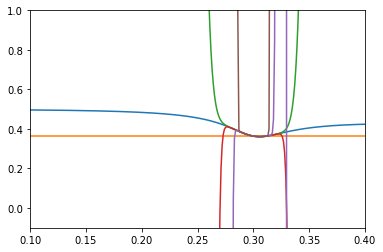

In [220]:
plt.plot(xx,p_err_t)
x0=0.3
for i in range(5):
    T = taylor(calc_p_err_next, x0, i*10, 0.01)
    plt.plot(xx,T(xx-x0))
plt.xlim([0.1,0.4])
plt.ylim([-0.1,1])
plt.show()

In [186]:
xx_approx = np.arange(-1,1,0.05)
int_err_approx = []
for x_next in xx_approx:

    y_next = gpa.predict(x_next.reshape(-1,1))
    gpn = gpa_next(gpa,x_next,y_next)

    D = perr_fdiff(gpn,range(5),x_next,h=0.01)

    f0 = lambda d, x, x0: np.ones_like(x)*d[0]
    f1 = lambda d, x, x0: np.ones_like(x)*d[0] + d[1]*(x-x0)
    f2 = lambda d, x, x0: np.ones_like(x)*d[0] + d[1]*(x-x0) + d[2]/2*(x-x0)**2
    f3 = lambda d, x, x0: np.ones_like(x)*d[0] + d[1]*(x-x0) + d[2]/2*(x-x0)**2 + d[3]/6*(x-x0)**3
    f4 = lambda d, x, x0: np.ones_like(x)*d[0] + d[1]*(x-x0) + d[2]/2*(x-x0)**2 + d[3]/6*(x-x0)**3 + d[4]/24*(x-x0)**4 

    l = 0.05
    integral = 0
    for m in range(3):
        integral += D[2*m]/factorial(2*m+1) * 2**(2*m+2) * l**(2*m+1)

    int_err_approx.append(integral)
    
int_err_approx = np.array(int_err_approx)

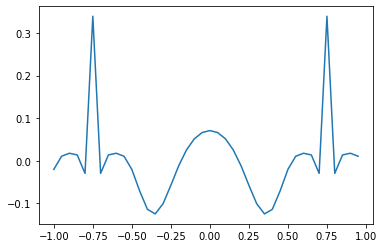

In [187]:
plt.plot(xx_approx, int_err_approx)

In [161]:
# x_next_list = np.arange(-1,1,0.01)
# util_approx = []

# def perr_next(gpa,x,xt,yt):
    
#     mu = mu_next(gpa,x,xt,yt)
#     sigma = sigma_next(gpa,x,xt)
    
#     return erfc(np.abs(mu)/sigma)/2

# for x_next in x_next_list:

#     y0 = gpa.predict(x_next.reshape(-1,1))
#     p1 = lambda b:  perr_next(gpa,b[0],b[1],y0)
#     ax = fdiff_2d(p1,[x_next,x_next],0.1)
#     # print(ax)
    
    
#     # m, s = g.predict(xx.reshape(-1,1), return_std=True)
#     # p_err_next = 1/2*erfc(np.abs(m)/s)
#     # util_exact.append(np.sum(p_err-p_err_next))

# util_exact = np.array(util_exact)

In [162]:
print(util_exact.shape)

(200,)


NameError: name 'util_approx' is not defined

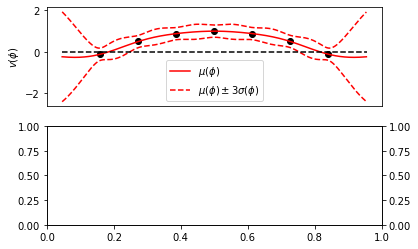

In [163]:
plt.subplot(2,1,1)
plt.plot(xx, mu_last, 'r')
plt.plot(xx,mu_last-3*sigma_last,'r--')
plt.plot(xx,mu_last+3*sigma_last,'r--')
plt.scatter(X,y,c='k')
plt.hlines(0,-1,1,'k','--')

plt.gca().set_xticks([], [])
plt.ylabel("$v(\phi)$")
plt.legend(["$\mu(\phi)$", "$\mu(\phi) \pm 3\sigma(\phi)$"])

#***

plt.subplot(2,1,2)
ax = plt.gca()
ax2 = ax.twinx()

ax.plot(x_next_list, util_approx, 'g')
ax2.plot(x_next_list,util_exact, 'b')

ax.set_xlabel('$\phi$')
ax.set_ylabel('Approx. Utility')
ax.tick_params(axis='y', colors='g')
ax.yaxis.label.set_color('g')

ax2.set_ylabel('Exact Utility')
ax2.tick_params(axis='y', colors='b')
ax2.yaxis.label.set_color('b')


plt.savefig('linearized_utility_demo01.png')
plt.show()

In [ ]:
gpa.kernel_.get_params()